Problem Statement: A company wants to target the right customers for app subscription using their app behaviour analysis.

Market: The users who use company's free product trial of 24 hours.

Product: App

Goal: To predict which users will not subscribe so that greater marketing efforts go into trying to convert them to paid users.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import time

In [2]:
dataset = pd.read_csv("appdata10.csv")

In [3]:
dataset.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [4]:
dataset.isnull().sum()

user                        0
first_open                  0
dayofweek                   0
hour                        0
age                         0
screen_list                 0
numscreens                  0
minigame                    0
used_premium_feature        0
enrolled                    0
enrolled_date           18926
liked                       0
dtype: int64

In [5]:
dataset.shape

(50000, 12)

In [6]:
dataset.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
dataset['hour'] = dataset.hour.str.slice(1,3).astype(int)

In [8]:
dataset2 = dataset.copy().drop(['user', 'screen_list', 'enrolled_date', 'first_open', 'enrolled'], axis=1)
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


CREATING HISTOGRAMS

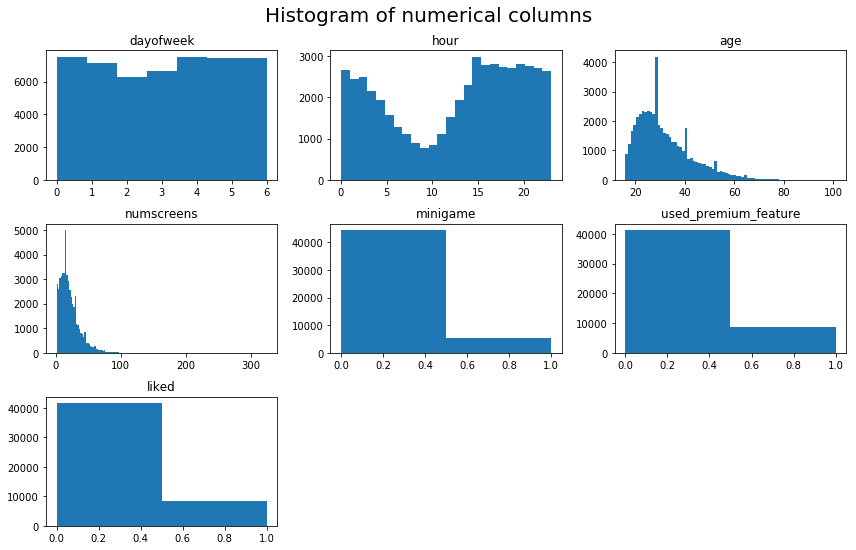

In [9]:
plt.figure(figsize=(12,8))
plt.suptitle("Histogram of numerical columns",fontsize=20)
for i in range(1, dataset2.shape[1]+1):
    plt.subplot(3,3,i)
    f=plt.gca()
    f.set_title(dataset2.columns.values[i-1])
    vals = np.size(dataset2.iloc[:,i-1].unique())
    plt.hist(dataset2.iloc[:,i-1], bins=vals)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

CORRELATION WITH RESPONSE

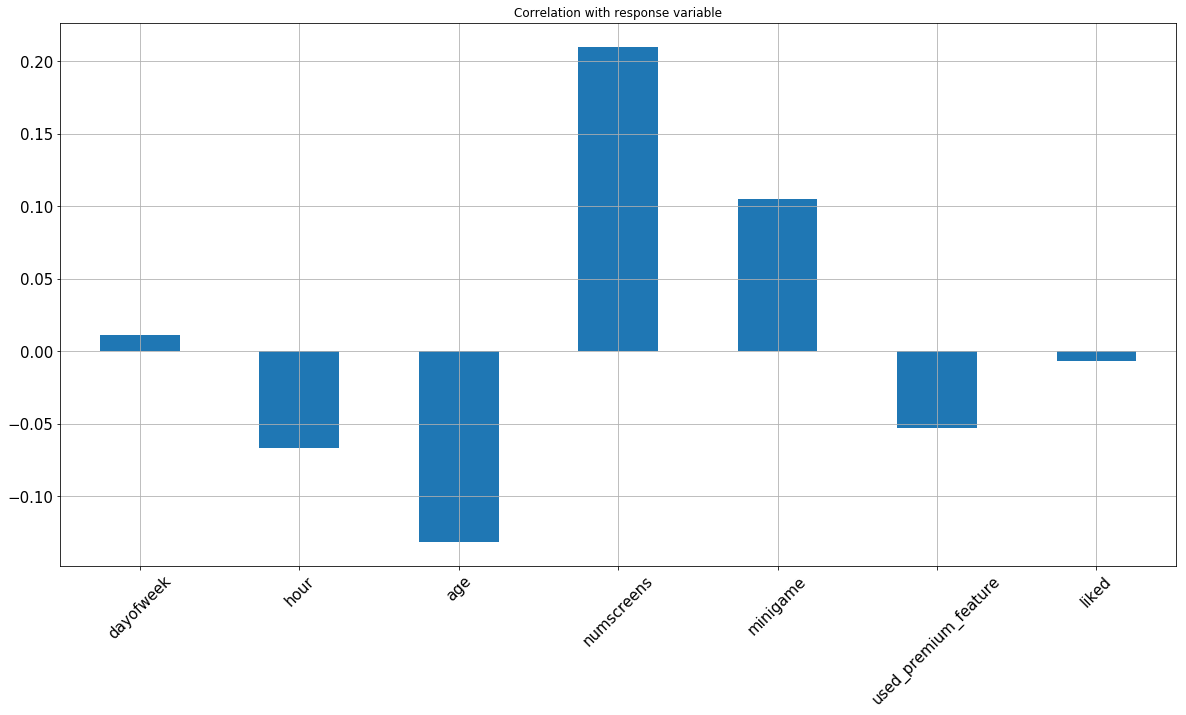

In [10]:
dataset2.corrwith(dataset.enrolled).plot.bar(figsize=(20,10), fontsize= 15, rot=45, title='Correlation with response variable',grid=True)
plt.show()

CREATING CORRELATION MATRIX

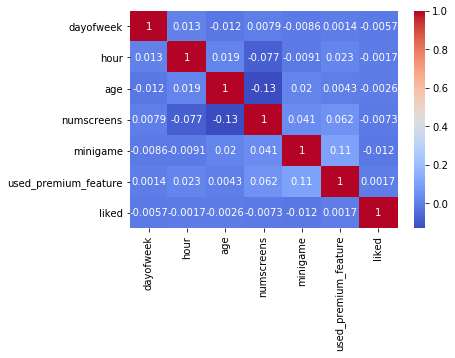

In [11]:
sns.heatmap(dataset2.corr(), cmap='coolwarm', annot=True)
plt.show()

FEATURE ENGINEERING- RESPONSE

In [12]:
dataset.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int32
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [13]:
dataset["first_open"] = [parser.parse(row_data) for row_data in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row_data) if isinstance(row_data, str) else row_data for row_data in dataset["enrolled_date"]]

In [14]:
dataset["difference"]= (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')

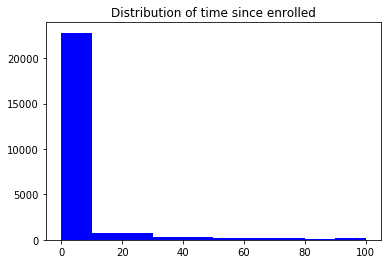

In [15]:
plt.hist(dataset['difference'].dropna(), color='blue', range= [0,100])
plt.title("Distribution of time since enrolled")
plt.show()

We find that most of the users enroll in the app within first 48 hours. We want our target to be independent of enrolled_date so as to make our model predictable based on the limited time period of 48 hours. Thus we perform feature engineering on target variable(enrolled).

In [16]:
dataset.loc[dataset.difference>48, 'enrolled'] = 0

In [17]:
dataset = dataset.drop(['first_open', 'enrolled_date', 'difference'], axis=1)

FEATURE ENGINEERING- SCREENS

In [18]:
top_screens = pd.read_csv('top_screens.csv').top_screens.values

In [19]:
dataset['screen_list'] = dataset.screen_list.astype(str) + ','

In [20]:
for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset["screen_list"] = dataset.screen_list.str.replace(sc+",","")

In [21]:
dataset["Other"] = dataset.screen_list.str.count(",")

In [22]:
dataset = dataset.drop(["screen_list"], axis=1)

In [23]:
dataset.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,Loan2,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,Other
0,235136,3,2,23,15,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,7
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6
4,51549,1,18,31,32,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,10


We group the similar screens so that there are no correlations in our model.

In [24]:
savings_screens = ["Saving1","Saving2","Saving2Amount","Saving4","Saving5","Saving6","Saving7","Saving8","Saving9","Saving10"]
dataset["Savingscount"] = dataset[savings_screens].sum(axis=1)
dataset = dataset.drop(savings_screens, axis=1)

In [25]:
cm_screens=["Credit1","Credit2","Credit3","Credit3Container","Credit3Dashboard"]
dataset["CMcount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(cm_screens,axis=1)

In [26]:
cc_screens = ["CC1","CC1Category","CC3"]
dataset["CCcount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(cc_screens, axis=1)

In [27]:
loan_screens = ["Loan","Loan2","Loan3","Loan4"]
dataset["Loancount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(loan_screens, axis=1)

In [28]:
dataset.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,Savingscount,CMcount,CCcount,Loancount
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


In [29]:
dataset.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'location', 'Institutions',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth', 'ProfilePage',
       'VerifyCountry', 'Cycle', 'idscreen', 'Splash', 'RewardsContainer',
       'EditProfile', 'Finances', 'Alerts', 'Leaderboard', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'ResendToken',
       'TransactionList', 'NetworkFailure', 'ListPicker', 'Other',
       'Savingscount', 'CMcount', 'CCcount', 'Loancount'],
      dtype='object')

In [30]:
dataset.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,Savingscount,CMcount,CCcount,Loancount
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.497000,0.165000,0.517760,...,0.014220,0.013340,0.013400,0.008200,0.007580,6.214260,0.365020,0.92776,0.176860,0.788400
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.499996,0.371184,0.499689,...,0.118398,0.114727,0.114981,0.090183,0.086733,3.672561,1.405511,1.21751,0.612787,0.677462
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.00000,0.000000,1.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.00000,0.000000,1.000000
max,373662.000000,6.000000,23.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,10.000000,5.00000,3.000000,3.000000


DATA PREPROCESSING

In [32]:
X= dataset.drop("enrolled", axis=1)
y= dataset["enrolled"]

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.2, random_state=0)

In [35]:
train_identifier=X_train["user"]
X_train = X_train.drop("user", axis=1)

In [36]:
test_identifier = X_test["user"]
X_test = X_test.drop("user", axis=1)

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
sc_X = StandardScaler()
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train))
X_test_scaled = pd.DataFrame(sc_X.transform(X_test))
X_train_scaled.columns = X_train.columns.values
X_test_scaled.columns = X_test.columns.values
X_train_scaled.index = X_train.index.values
X_test_scaled.index = X_test.index.values

In [39]:
X_train = X_train_scaled
X_test = X_test_scaled

In [40]:
X_train

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,location,Institutions,VerifyPhone,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,Savingscount,CMcount,CCcount,Loancount
20330,-0.504961,1.000837,0.025525,-1.026726,-0.346830,2.186018,2.246319,-1.039218,-0.644848,-1.052581,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,-1.147303,-0.260877,-0.763372,-0.289185,1.785389
17532,-0.997389,1.135280,-0.898034,1.328829,2.883254,-0.457453,-0.445173,0.962262,1.550753,0.950046,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,1.839740,-0.260877,0.057524,-0.289185,0.309800
45819,-1.489818,-1.150250,-0.528611,4.066366,2.883254,-0.457453,-0.445173,-1.039218,1.550753,-1.052581,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,1.025092,-0.260877,0.878421,1.336593,1.785389
34807,0.479896,0.059736,-0.620967,0.182883,2.883254,-0.457453,-0.445173,0.962262,-0.644848,-1.052581,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,1.025092,-0.260877,-0.763372,-0.289185,0.309800
31888,-0.012532,0.463065,1.687932,-0.644744,-0.346830,-0.457453,-0.445173,0.962262,-0.644848,0.950046,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,-0.875753,-0.260877,0.878421,-0.289185,-1.165789
48372,1.464753,1.135280,0.302593,0.055556,-0.346830,-0.457453,2.246319,-1.039218,-0.644848,0.950046,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,0.481993,1.857638,0.057524,-0.289185,1.785389
5524,-0.504961,0.866394,-0.898034,-0.326426,2.883254,2.186018,-0.445173,-1.039218,-0.644848,-1.052581,...,-0.119697,-0.11742,8.629699,-0.091207,-0.087221,-1.147303,-0.260877,0.057524,2.962372,0.309800
38032,-0.997389,-0.612478,-0.805679,1.328829,-0.346830,2.186018,-0.445173,0.962262,-0.644848,0.950046,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,1.025092,-0.260877,-0.763372,-0.289185,0.309800
14944,-0.012532,-1.419136,0.302593,-0.517417,-0.346830,-0.457453,-0.445173,-1.039218,1.550753,-1.052581,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,-1.147303,-0.260877,-0.763372,-0.289185,0.309800
22793,-0.504961,0.731951,1.318508,0.501202,-0.346830,-0.457453,2.246319,0.962262,1.550753,0.950046,...,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,-0.332655,-0.260877,2.520213,-0.289185,0.309800


CREATING THE CLASSIFICATION MODEL

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
classifier = LogisticRegression(random_state=0, penalty="l1")

In [43]:
classifier.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
y_pred = classifier.predict(X_test)

EVALUATING THE MODEL

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [46]:
cm = confusion_matrix(y_test, y_pred)

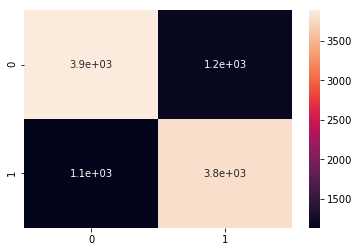

In [47]:
sns.heatmap(cm, annot=True)
plt.show()

In [48]:
accuracy_score(y_test,y_pred)

0.7681

In [49]:
precision_score(y_test,y_pred)

0.7618952017667135

In [50]:
recall_score(y_test,y_pred)

0.7700892857142857

In [51]:
f1_score(y_test,y_pred)

0.7659703300030276

VALIDATING THE MODEL USING K-FOLD CROSS VALIDATION

In [52]:
from sklearn.model_selection import cross_val_score
accuracies= cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
print("Logistic Accuracy: %0.3f(+/- %0.3f)" %(accuracies.mean(), accuracies.std()*2))

Logistic Accuracy: 0.767(+/- 0.010)


In [53]:
final_results = pd.concat([y_test, test_identifier], axis=1).dropna()

In [54]:
final_results["predicted_results"]= y_pred

FINAL RESULT INTO A DATAFRAME

In [56]:
final_results[["user","enrolled","predicted_results"]].reset_index(drop=True)

,user,enrolled,predicted_results
0,239786,1,1
1,279644,1,1
2,98290,0,0
3,170150,1,1
4,237568,1,1
5,65042,1,0
6,207226,1,1
7,363062,0,0
8,152296,1,1
9,64484,0,0


Conclusion: We validated our results using K fold cross validation and got around 77% accuracy and almost similar precision, recall and f1_score. Thus our model can help us strategize marketing campaings to the target audience and increase the number of subscriptions significantly. 